Task - Linear regression Aim Perform a linear regression analysis (of your slice) of the Instacart dataset, predicting the number of days between orders.

Detail The problem to solve takes the form of Linear Regression with categorical independent variables.

Consider the sequence of orders placed by a customer. The hypothesis is that the typical product mix for that customer can be used to predict when the next order will be placed.

For training data, take an 80% subset of "relevant" orders, across all "relevant" users. From the first to the second last order, determine the product mix for that user, as well as the number of days until the next order for that user.

The training data is the remaining 20% subset of "relevant" orders, across all "relevant" users.

For example, if there were just 1 user and that user placed 11 orders, the training set could include the product mixes for each of the following 8 orders: 1, 2, 4, 5, 6, 7, 9, 10, together with the "days between orders" for each of the 8 order pairs (1,2), (2,3), (4,5), (5,6), (6,7), (7,8), (9,10), (10,11). In this case, the test data would include the product mix for order 3 and 8, together with the "days between orders" for each of the 2 order pairs (3,4) and (8,9).

Please note that the proposed 80:20 split is across user x order combinations.

Also, in practice, relevant implies an unbiased subset chosen to make the problem tractable with the computing resources available to each student.

For Independent variables, the product (mix) for order i-1 can be used, and the Dependent variable is the number of days between order i-1 and order i in that sequence for a given user.

Therefore the number of observations in the observation matrix is the number of users times the number of orders for each user.

Since there are 49688 distinct products, the dimensionality of the problem is very high, so students need to take account of this using:

roll up to aisle (134 unique) or department (21 unique) and build model accordingly use PCA to reduce the dimensions (of products, aisles and/or departments), and solve using the reduced-dimension model use regularisation and fit a constrained model. Disclaimers/Comments It is possible to obtain either per-user predictions (by solving a separate regression problem for each user) or a user-agnostic prediction (by merging the data for many users). It would be interesting to try both and compare, explaining what you find.

Much of this task relates to dimensionality reduction. In traditional BI, this would be done using roll-ups (e.g., from product to aisle), but linear regression offers other options. The BI approach is easier to interpret, because of the "meaningful" labels, but does it work as well? Give reasons for your answer!

Validating the results requires analysis of the outputs (and not just the predictions) of the linear regression model, e.g., R-squared and any other metrics you believe are helpful here.

Grading Outline 3 x 25% for each of the 3 regression model x dimensionality reduction options above, where the 25% consists of 5% Visualisation 10% formulation and solving 10% Validation/Comments/analysis. 25% for comparing per-user and multi-user models, and different methods for dimensionality reduction.

# IMPORTS

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")

from itertools import combinations, groupby
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from sklearn import linear_model
from sklearn import preprocessing, cross_validation, svm
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
import sys

C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# READ IN CSVs

In [2]:
orders = pd.read_csv('instacart_2017_05_01/my_orders.csv',index_col=0)
products = pd.read_csv('instacart_2017_05_01/products.csv')
aisles = pd.read_csv('instacart_2017_05_01/aisles.csv')
departments = pd.read_csv('instacart_2017_05_01/departments.csv')
orders_products_prior_full = pd.read_csv('instacart_2017_05_01/my_order_products__prior.csv',index_col=0)
orders_products_train_full = pd.read_csv('instacart_2017_05_01/my_order_products__train.csv',index_col=0)
orders_products = pd.concat([orders_products_prior_full, orders_products_train_full])

#build the master table 
order_products_orders = pd.merge(orders_products, orders, on="order_id")
order_products_products = pd.merge(order_products_orders, products, on="product_id")
order_products_aisles = pd.merge(order_products_products, aisles, on="aisle_id")
order_products_departments = pd.merge(order_products_aisles, departments, on="department_id")
order_products_departments.head()
order_products_master = order_products_departments.copy().set_index("order_id").sort_index()
order_products_master.head()


,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
order_id,,,,,,,,,,,,,,
8938,49235,1,1,179033,prior,17,3,10,12.0,Organic Half & Half,53,16,cream,dairy eggs
8938,15680,5,1,179033,prior,17,3,10,12.0,Red Plastic Cups,111,17,plates bowls cups flatware,household
8938,13032,2,1,179033,prior,17,3,10,12.0,Cinnamon Toast Crunch,121,14,cereal,breakfast
8938,9007,7,0,179033,prior,17,3,10,12.0,Frosted Flakes,121,14,cereal,breakfast
8938,26348,3,1,179033,prior,17,3,10,12.0,Mixed Fruit Fruit Snacks,50,19,fruit vegetable snacks,snacks


# Calculate top 'performers'

In [3]:

c = order_products_master["product_id"].value_counts().gt(18) #18 returns top 10 (11/876)
top_ten_products_df = order_products_master.loc[order_products_master["product_id"].isin(c[c].index)]
top_ten_products = top_ten_products_df["product_id"].unique()

c = order_products_master["product_id"].value_counts().gt(13) #13 returns top 20 (21/876)
top_twenty_products_df = order_products_master.loc[order_products_master["product_id"].isin(c[c].index)]
top_twenty_products = [item for item in top_twenty_products_df["product_id"].unique() if item not in top_ten_products]

c = order_products_master["product_id"].value_counts().gt(8) #8 returns top 50 (53/876)
top_fifty_products_df = order_products_master.loc[order_products_master["product_id"].isin(c[c].index)]
top_fifty_products = [item for item in top_fifty_products_df["product_id"].unique() if item not in top_twenty_products and item not in top_ten_products]

c = order_products_master["product_id"].value_counts().gt(4) #4 returns top 100 (123/876)
top_hundred_products_df = order_products_master.loc[order_products_master["product_id"].isin(c[c].index)]
top_hundred_products = [item for item in top_hundred_products_df["product_id"].unique() if item not in top_fifty_products and item not in top_twenty_products and item not in top_ten_products]

top_ten_products_df.head()
print(len(top_ten_products))
print(len(top_twenty_products))
print(len(top_fifty_products))
print(len(top_hundred_products))

11
10
32
70


# Check how many top products each order has

In [4]:



orders_enhanced = orders.copy()
orders_enhanced["days_until_next_order"] = orders["days_since_prior_order"].shift(-1).dropna()

item_counts = []
top_ten_checks = []
top_ten_counts = []
top_twenty_checks = []
top_twenty_counts = []
top_fifty_checks = []
top_fifty_counts = []
top_hundred_checks = []
top_hundred_counts = []

for orderid in orders_enhanced["order_id"]:
    inner_products = order_products_departments.loc[order_products_departments["order_id"] == orderid ]["product_id"].unique()
    item_counts.append(len(inner_products))
    
    top_ten_count = len([item for item in inner_products if item in top_ten_products])
    top_ten_items = 1 if top_ten_count > 0 else 0
    top_ten_checks.append(top_ten_items)
    top_ten_counts.append(top_ten_count)
    
    top_twenty_count = len([item for item in inner_products if item in top_twenty_products])
    top_twenty_items = 1 if top_twenty_count > 0 else 0
    top_twenty_checks.append(top_twenty_items)
    top_twenty_counts.append(top_twenty_count)
    
    top_fifty_count = len([item for item in inner_products if item in top_fifty_products])
    top_fifty_items = 1 if top_twenty_count > 0 else 0
    top_fifty_checks.append(top_fifty_items)
    top_fifty_counts.append(top_fifty_count)
    
    top_hundred_count = len([item for item in inner_products if item in top_hundred_products])
    top_hundred_items = 1 if top_hundred_count > 0 else 0  
    top_hundred_checks.append(top_hundred_items)
    top_hundred_counts.append(top_hundred_count)

orders_enhanced["item_count"] = item_counts
orders_enhanced["contains_top_ten"] = top_ten_checks
orders_enhanced["top_ten_count"] = top_ten_counts
orders_enhanced["contains_top_twenty"] = top_twenty_checks
orders_enhanced["top_twenty_count"] = top_twenty_counts
orders_enhanced["contains_top_fifty"] = top_fifty_checks
orders_enhanced["top_fifty_count"] = top_fifty_counts
orders_enhanced["contains_top_hundred"] = top_hundred_checks
orders_enhanced["top_hundred_count"] = top_hundred_counts
orders_enhanced.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_until_next_order,item_count,contains_top_ten,top_ten_count,contains_top_twenty,top_twenty_count,contains_top_fifty,top_fifty_count,contains_top_hundred,top_hundred_count
30650,3308693,1886,prior,1,4,8,NaN,6.0,3,1,1,0,0,0,1,1,1
30651,1019221,1886,prior,2,3,8,6.0,7.0,4,0,0,1,1,1,1,1,1
30652,3410026,1886,prior,3,3,10,7.0,5.0,4,1,1,1,1,1,1,1,1
30653,2727369,1886,prior,4,1,8,5.0,7.0,2,1,1,0,0,0,1,0,0
30654,94907,1886,prior,5,1,16,7.0,7.0,7,1,1,1,1,1,1,1,3


C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


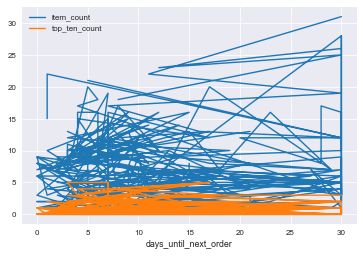

In [5]:
#Plotting item count, orders with most popular products and number of popular products against days until next order
#clearly no help
orders_enhanced.plot(x="days_until_next_order", y=["item_count","top_ten_count"], kind="line")

# reduce and regression

In [6]:
#reduced_table = orders_enhanced[["order_dow","order_hour_of_day","item_count","top_ten_count","top_twenty_count","top_fifty_count","top_hundred_count","days_until_next_order"]]
reduced_table = orders_enhanced[["contains_top_ten","contains_top_twenty","contains_top_fifty","contains_top_hundred","days_until_next_order"]]
reduced_table.head()

,contains_top_ten,contains_top_twenty,contains_top_fifty,contains_top_hundred,days_until_next_order
30650,1,0,0,1,6.0
30651,0,1,1,1,7.0
30652,1,1,1,1,5.0
30653,1,0,0,0,7.0
30654,1,1,1,1,7.0


In [7]:
reduced_table.dropna(inplace=True)
y = np.array(reduced_table['days_until_next_order'])
X = np.array(reduced_table.drop(['days_until_next_order'], 1))

X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

for k in ['linear','sigmoid','poly','rbf']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence) 
    
X_lately = X[-10:]
X = X[:-10]
forecast_set = clf.predict(X_lately)
print(forecast_set, confidence, 10)

linear -0.1877604819606853
sigmoid -0.18204485503821455
poly -0.19205962816960387
rbf -0.2115103063057504
[12.10016234 12.10016234  7.90029472 12.10016234 12.10016234  7.90003311
  7.8995255   9.56710671  9.56710671  7.90029472] -0.2115103063057504 10


C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


# doesn't look great, lets try a single user

In [8]:
single_user_enhanced = orders_enhanced.loc[orders_enhanced['user_id'] == 1886]
#single_user_table = single_user_enhanced[["order_dow","order_hour_of_day","item_count","top_ten_count","top_twenty_count","top_fifty_count","top_hundred_count","days_until_next_order"]]
single_user_table = single_user_enhanced[["contains_top_ten","contains_top_twenty","contains_top_fifty","contains_top_hundred","days_until_next_order"]]

single_user_table.dropna(inplace=True)
y = np.array(single_user_table['days_until_next_order'])
X = np.array(single_user_table.drop(['days_until_next_order'], 1))

X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
for k in ['linear','sigmoid','poly','rbf']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence)  
    

X_subset = X[-1:]
X = X[:-1]
forecast_set = clf.predict(X_subset)
print(forecast_set, confidence, 1)

linear -1.0948780931360123
sigmoid -1.1240834115281246
poly -1.1533057112742542
rbf -0.8915681654631507
[6.90029598] -0.8915681654631507 1


C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


# lets try more columns

In [9]:

top_fifty_ids = np.concatenate([top_ten_products,top_twenty_products,top_fifty_products])
top_fifty_cols = pd.DataFrame(top_fifty_ids,columns=['product_id'])
top_fifty_cols = pd.merge(top_fifty_cols, products, on="product_id")
top_fifty_product_names = top_fifty_cols["product_name"]

order_products_master.loc[8938]

,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
order_id,,,,,,,,,,,,,,
8938,49235,1,1,179033,prior,17,3,10,12.0,Organic Half & Half,53,16,cream,dairy eggs
8938,15680,5,1,179033,prior,17,3,10,12.0,Red Plastic Cups,111,17,plates bowls cups flatware,household
8938,13032,2,1,179033,prior,17,3,10,12.0,Cinnamon Toast Crunch,121,14,cereal,breakfast
8938,9007,7,0,179033,prior,17,3,10,12.0,Frosted Flakes,121,14,cereal,breakfast
8938,26348,3,1,179033,prior,17,3,10,12.0,Mixed Fruit Fruit Snacks,50,19,fruit vegetable snacks,snacks
8938,5028,4,1,179033,prior,17,3,10,12.0,Strawberry Twizzlers,45,19,candy chocolate,snacks
8938,37710,6,1,179033,prior,17,3,10,12.0,Trail Mix,125,19,trail mix snack mix,snacks


In [10]:
order_products_master.head()
print(len(order_products_master))
orders_ids = np.unique(order_products_master.index.values)
print(len(orders_ids))
rows = []

orders_enhanced = orders.copy()

for orderid in orders_ids:   
    row = {}
    inner_list = pd.DataFrame(order_products_master.loc[orderid,["product_name"]])
    row["order_id"] = orderid
    for top_prod in top_fifty_product_names:        
        row[top_prod] = 1 if top_prod in inner_list[inner_list.columns[0]].values else 0        
    rows.append(row)
df_timeline_all_users = pd.DataFrame(rows, columns=rows[0].keys())

#lets merge this with our order_products_table
df_timeline_complete = pd.merge(orders, df_timeline_all_users, on="order_id", left_index=True).drop(['order_id','user_id', 'eval_set', "order_number"], axis=1)
df_timeline_complete["days_until_next_order"] = df_timeline_complete["days_since_prior_order"].shift(-1)
df_timeline_complete.dropna(inplace=True)
df_timeline_complete.head()

2374
316


,order_dow,order_hour_of_day,days_since_prior_order,Organic Half & Half,Peach Yoghurt,Banana,Organic Reduced Fat 2% Milk,Hass Avocados,Apple Honeycrisp Organic,Natural Pure Sparkling Water,...,Oh My Yog! Gingered Pear Trilayer Yogurt,Cucumber Kirby,M&M's Vanilla Lowfat Yogurt,Indian Samosa Wrap,Original Rice Krispies Treats,Blueberries,Strawberries,Garden Veggie Straws Sea Salt,Organic Baby Arugula,days_until_next_order
98,3,8,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
314,3,10,7.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.0
252,1,8,5.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.0
8,1,16,7.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.0
287,1,9,7.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.0


In [11]:
y = np.array(df_timeline_complete['days_until_next_order']).copy()
X = np.array(df_timeline_complete.drop(['days_since_prior_order','days_until_next_order','order_hour_of_day','order_dow'], 1))


X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
for k in ['linear','sigmoid','poly','rbf']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence) 

linear 0.07569723018940022
sigmoid 0.05593766976048208
poly 0.011836599864278763
rbf 2.191278461571855e-05


C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [12]:
y = df_timeline_complete['days_until_next_order'].copy()
X = df_timeline_complete.drop(['days_since_prior_order','days_until_next_order','order_hour_of_day','order_dow'], 1)


model = linear_model.LinearRegression()
def findNextBestPredictor(X,foundPredictors):
    nP = X.shape[1] # number of columns in X
    allPredictors = list(X) # See https://stackoverflow.com/a/19483025
    predictorsToSearch = set(allPredictors) - set(foundPredictors)
    maxScore = 0 # can usually do better than this!
    for predictor in predictorsToSearch: # loop over all remaining columns (predictors) in X
        trialPredictors = set(foundPredictors)
        trialPredictors.add(predictor) # Add this predictor to the existing predictors
        XcolSubset = X.loc[:,trialPredictors] # all rows and just the trial predictors
        model.fit(XcolSubset, y) # fit the model to y
        score = model.score(XcolSubset, y)
        if score > maxScore: # identify the largest score and its associated predictor
            maxScore = score
            bestPredictorFound = predictor

    return (maxScore, bestPredictorFound)

findNextBestPredictor(X, list())

(0.06843432699993612, 'Cucumber Kirby')

['Cucumber Kirby', 'Organic Half & Half', 'Banana', 'Natural Pure Sparkling Water', 'Organic Fat Free Milk', 'Milano', 'Dried Mango', 'Zero Rise Orange', 'Bag of Organic Bananas', 'Simply Naked Pita Chips', 'Organic Hass Avocado', 'Organic Strawberries', "M&M's Vanilla Lowfat Yogurt", 'Organic Sweet Mini Peppers', 'Organic Cucumber', 'Uncured Genoa Salami', 'Butter Lettuce', 'Organic Nectarine', 'Peach Yoghurt', 'Large Lemon', 'Tart Cherry Yoghurt', 'Original Rice Krispies Treats', 'Organic Reduced Fat 2% Milk', 'Garden Veggie Straws Sea Salt', 'Goldfish Cheddar Baked Snack Crackers Multi Packs', 'Organic Raspberries', 'Indian Samosa Wrap', 'Organic Fuji Apple', 'Organic Avocado', 'Organic Baby Arugula', 'Organic Z  Mixed Berry Fruit Rope', 'Orange Calcium & Vitamin D Pulp Free', 'Organic Baby Carrots', 'Strawberries', 'Organic Blueberries', 'Carrot Raisin Flax Muffins', 'Oh My Yog! Gingered Pear Trilayer Yogurt', 'Apple Honeycrisp Organic', 'Grilled Chicken Breast Strips', 'Nine Grain

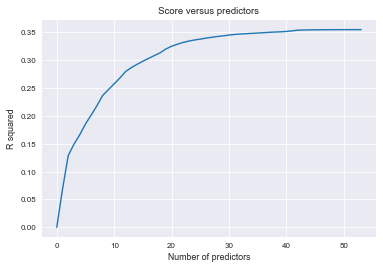

In [13]:
nP = X.shape[1]
scores = [0]
foundPredictors = list()

for i in range(nP): # loop over all columns (predictors) in X
    (score, bestPredictorFound) = findNextBestPredictor(X, foundPredictors)
    foundPredictors.append(bestPredictorFound)
    scores.append(score)

print(foundPredictors)
print(scores)

plt.title("Score versus predictors")
plt.xlabel('Number of predictors') 
plt.ylabel('R squared')
plt.plot(scores)

# alternate timeline - departments

In [14]:
rows = []

orders_enhanced = orders.copy()
dept_names = order_products_master["department"].unique()
print(len(departments)) #departments
print(len(dept_names)) #departments listed in orders
for orderid in orders_ids:   
    row = {}
    inner_list = pd.DataFrame(order_products_master.loc[orderid,["department"]])
    for dept in dept_names:
        row[dept] = 1 if dept in inner_list[inner_list.columns[0]].values else 0 
    row["order_id"] = orderid    
    rows.append(row)
df_alt_timeline_all_users = pd.DataFrame(rows, columns=rows[0].keys())

#lets merge this with our order_products_table
df_alt_timeline_all_users = pd.merge(orders, df_alt_timeline_all_users, on="order_id", left_index=True).drop(['order_id','user_id', 'eval_set', "order_number"], axis=1)
df_alt_timeline_all_users["days_until_next_order"] = df_timeline_complete["days_since_prior_order"].shift(-1)
df_alt_timeline_all_users.dropna(inplace=True)
df_alt_timeline_all_users.head()

21
18


,order_dow,order_hour_of_day,days_since_prior_order,dairy eggs,household,breakfast,snacks,bulk,beverages,meat seafood,...,deli,bakery,pantry,canned goods,dry goods pasta,international,personal care,babies,missing,days_until_next_order
98,3,8,6.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7.0
314,3,10,7.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5.0
252,1,8,5.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7.0
8,1,16,7.0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,7.0
287,1,9,7.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7.0


C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


linear -0.08163371794170993
sigmoid -0.027240206841584014
poly -0.1033227478562968
rbf -0.012851175298917772
['bakery', 'dry goods pasta', 'pantry', 'household', 'meat seafood', 'produce', 'canned goods', 'babies', 'bulk', 'dairy eggs', 'frozen', 'beverages', 'personal care', 'snacks', 'missing', 'breakfast', 'international', 'deli']
[0, 0.0476668407427886, 0.08129773151200115, 0.10115545840331151, 0.11490817218303663, 0.1273118514953091, 0.13752183370330007, 0.14613765516210153, 0.15543664029721815, 0.163597091139414, 0.1689662228366009, 0.1704448979251566, 0.17162489268715508, 0.17213724774242423, 0.1726473904747553, 0.1729228972466882, 0.17310747041401509, 0.17319232348905822, 0.1732559848294415]


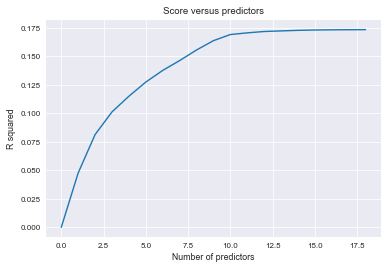

In [15]:
y = np.array(df_alt_timeline_all_users['days_until_next_order']).copy()
X = np.array(df_alt_timeline_all_users.drop(['days_since_prior_order','days_until_next_order','order_hour_of_day','order_dow'], 1))


X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
for k in ['linear','sigmoid','poly','rbf']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence) 
    
y = df_alt_timeline_all_users['days_until_next_order'].copy()
X = df_alt_timeline_all_users.drop(['days_since_prior_order','days_until_next_order','order_hour_of_day','order_dow'], 1)
    
model = linear_model.LinearRegression()



nP = X.shape[1]
scores = [0]
foundPredictors = list()

for i in range(nP): # loop over all columns (predictors) in X
    (score, bestPredictorFound) = findNextBestPredictor(X, foundPredictors)
    foundPredictors.append(bestPredictorFound)
    scores.append(score)

print(foundPredictors)
print(scores)

plt.title("Score versus predictors")
plt.xlabel('Number of predictors') 
plt.ylabel('R squared')
plt.plot(scores)

# alternate timeline - ailses

In [16]:
rows = []

orders_enhanced = orders.copy()
aisle_names = order_products_master["aisle"].unique()
print(len(aisles)) #aisles
print(len(aisle_names)) #aisles listed in orders
for orderid in orders_ids:   
    row = {}
    inner_list = pd.DataFrame(order_products_master.loc[orderid,["aisle"]])
    for aisle in aisle_names:
        row[aisle] = 1 if aisle in inner_list[inner_list.columns[0]].values else 0 
    row["order_id"] = orderid    
    rows.append(row)
df_alt_timeline_all_users = pd.DataFrame(rows, columns=rows[0].keys())

#lets merge this with our order_products_table
df_alt_timeline_all_users = pd.merge(orders, df_alt_timeline_all_users, on="order_id", left_index=True).drop(['order_id','user_id', 'eval_set', "order_number"], axis=1)
df_alt_timeline_all_users["days_until_next_order"] = df_timeline_complete["days_since_prior_order"].shift(-1)
df_alt_timeline_all_users.dropna(inplace=True)
df_alt_timeline_all_users.head()


134
109


,order_dow,order_hour_of_day,days_since_prior_order,cream,plates bowls cups flatware,cereal,fruit vegetable snacks,candy chocolate,trail mix snack mix,butter,...,air fresheners candles,frozen appetizers sides,frozen breads doughs,kitchen supplies,more household,soap,beauty,frozen meat seafood,missing,days_until_next_order
98,3,8,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
314,3,10,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
252,1,8,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
8,1,16,7.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
287,1,9,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0


linear 0.004008791680657708
sigmoid -0.16075387658532403
poly -0.1869840860508576
rbf -0.13326437935318136
['poultry counter', 'milk', 'soup broth bouillon', 'cream', 'instant foods', 'bread', 'mint gum', 'frozen appetizers sides', 'more household', 'frozen vegan vegetarian', 'spices seasonings', 'dry pasta', 'preserved dips spreads', 'refrigerated', 'dish detergents', 'juice nectars', 'canned meals beans', 'paper goods', 'bulk dried fruits vegetables', 'vitamins supplements', 'protein meal replacements', 'cereal', 'butter', 'beauty', 'salad dressing toppings', 'fresh vegetables', 'energy sports drinks', 'cleaning products', 'fresh herbs', 'canned jarred vegetables', 'laundry', 'granola', 'buns rolls', 'trash bags liners', 'trail mix snack mix', 'breakfast bars pastries', 'popcorn jerky', 'feminine care', 'crackers', 'honeys syrups nectars', 'missing', 'baking ingredients', 'eggs', 'doughs gelatins bake mixes', 'baby bath body care', 'skin care', 'baking supplies decor', 'coffee', 'fre

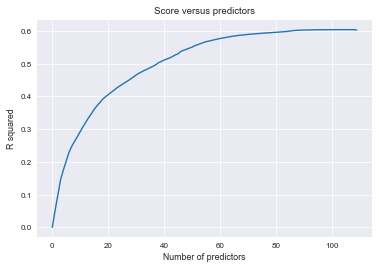

In [17]:
y = np.array(df_alt_timeline_all_users['days_until_next_order']).copy()
X = np.array(df_alt_timeline_all_users.drop(['days_since_prior_order','days_until_next_order','order_hour_of_day','order_dow'], 1))



X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
for k in ['linear','sigmoid','poly','rbf']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence) 
    
y = df_alt_timeline_all_users['days_until_next_order'].copy()
X = df_alt_timeline_all_users.drop(['days_since_prior_order','days_until_next_order','order_hour_of_day','order_dow'], 1)
    
model = linear_model.LinearRegression()


nP = X.shape[1]
scores = [0]
foundPredictors = list()

for i in range(nP): # loop over all columns (predictors) in X
    (score, bestPredictorFound) = findNextBestPredictor(X, foundPredictors)
    foundPredictors.append(bestPredictorFound)
    scores.append(score)

print(foundPredictors)
print(scores)

plt.title("Score versus predictors")
plt.xlabel('Number of predictors') 
plt.ylabel('R squared')
plt.plot(scores)

In [18]:
y = np.array(df_alt_timeline_all_users['days_until_next_order']).copy()
X = np.array(df_alt_timeline_all_users.drop(['days_since_prior_order','days_until_next_order','order_hour_of_day','order_dow'], 1))

lm = LinearRegression()

y = np.array(df_alt_timeline_all_users['days_until_next_order']).copy()
X = np.array(df_alt_timeline_all_users[['poultry counter', 'milk', 'soup broth bouillon', 'cream', 'instant foods', 'bread', 'mint gum', 'frozen appetizers sides', 'more household', 'frozen vegan vegetarian', 'spices seasonings', 'dry pasta', 'preserved dips spreads', 'refrigerated', 'dish detergents', 'juice nectars', 'canned meals beans', 'paper goods', 'bulk dried fruits vegetables', 'vitamins supplements', 'protein meal replacements', 'cereal', 'butter', 'beauty', 'salad dressing toppings', 'fresh vegetables', 'energy sports drinks', 'cleaning products', 'fresh herbs', 'canned jarred vegetables', 'laundry', 'granola', 'buns rolls', 'trash bags liners', 'trail mix snack mix', 'breakfast bars pastries', 'popcorn jerky', 'feminine care', 'crackers', 'honeys syrups nectars']])
print(np.sqrt(-cross_val_score(lm, X, y, cv=10, scoring="neg_mean_squared_error")).mean())

y = np.array(df_alt_timeline_all_users['days_until_next_order']).copy()
X = np.array(df_alt_timeline_all_users[['poultry counter', 'milk', 'soup broth bouillon', 'cream', 'instant foods', 'bread', 'mint gum', 'frozen appetizers sides', 'more household', 'frozen vegan vegetarian', 'spices seasonings', 'dry pasta', 'preserved dips spreads', 'refrigerated']])
print(np.sqrt(-cross_val_score(lm, X, y, cv=100, scoring="neg_mean_squared_error")).mean())

9.317280680522632
7.266816395777985


In [19]:

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
for k in ['linear','sigmoid','poly','rbf']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence) 
    subset = X[-10:]
    forecast_set = clf.predict(subset)
    print(forecast_set, confidence, 10)


linear 0.08371265376393922
[ 9.49932636  6.89997081  9.49932636  6.89997081  6.89997081  9.49932636
  6.89997081  8.09997081 11.50073836  8.09997081] 0.08371265376393922 10
sigmoid -0.002028538156622295
[8.23048774 8.00865823 8.23048774 8.00865823 8.00865823 8.23048774
 8.00865823 8.79303899 9.29219038 8.79303899] -0.002028538156622295 10
poly -0.04991072005929076
[8.47576531 8.49836006 8.47576531 8.49836006 8.49836006 8.47576531
 8.49836006 8.50273324 8.50528426 8.50273324] -0.04991072005929076 10
rbf -0.004215780385396162
[7.72750032 7.15024518 7.72750032 7.15024518 7.15024518 7.72750032
 7.15024518 8.26350127 9.33194894 8.26350127] -0.004215780385396162 10
